> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset: Factors of No-Show to Dr. Appointments


## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
    <ul>
        <li><a href="eda_waitdays">Wait Days Exploration</a></li>
        <li><a href="eda_age">Wait Days Exploration</a></li>
        <li><a href="eda_text">Wait Days Exploration</a></li>
        <li><a href="eda_alcoholism">Wait Days Exploration</a></li>
        <li><a href="eda_location">Wait Days Exploration</a></li>
        
   </ul>

<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected for analysis. At the end of this section, describe the questions that you plan on exploring over the course of the report. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

> If you haven't yet selected and downloaded your data, make sure you do that first before coming back here. In order to work with the data in this workspace, you also need to upload it to the workspace. To do so, click on the jupyter icon in the upper left to be taken back to the workspace directory. There should be an 'Upload' button in the upper right that will let you add your data file(s) to the workspace. You can then click on the .ipynb file name to come back here.

In [2]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline 
matplotlib.style.use('ggplot')
import seaborn as sb
from patsy import dmatrices


from sklearn.preprocessing import MinMaxScaler as min_max_scaler, OneHotEncoder as ohe, LabelEncoder as le
from sklearn.linear_model import LogisticRegression as logReg
from sklearn.ensemble import RandomForestClassifier as rf, GradientBoostingClassifier as gbc
from sklearn.svm import SVC as svc
from sklearn.metrics import confusion_matrix as c_m, precision_score as p_s, recall_score as r_s, roc_auc_score as roc, f1_score as f1
from sklearn.model_selection import train_test_split as tts, StratifiedKFold as skf 
from sklearn.utils import resample

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
aux_df = pd.read_csv('hospital_rankings.csv', sep = ';')
brazil_ranks = aux_df.query('Country=="BRA"')
brazil_ranks.drop(['Country'], axis=1, inplace=True)
brazil_ranks.Institution.values

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array(['Universidade de Sao Paulo', 'Universidade Estadual de Campinas',
       'Universidade Estadual Paulista Julio de Mesquita Filho',
       'Universidade Federal do Rio de Janeiro',
       'Universidade Federal do Rio Grande do Sul',
       'Universidade Federal de Minas Gerais',
       'Universidade Federal de Sao Paulo',
       'Hospital de Cancer de Barretos', 'Fundacao Oswaldo Cruz',
       'Universidade Federal de Santa Catarina',
       'Empresa Brasileira de Pesquisa Agropecuaria',
       'Universidade do Extremo Sul Catarinense',
       'Universidade Federal do Parana', 'Universidade de Brasilia',
       'Instituto Butantan', 'Universidade Federal de Pernambuco',
       'Universidade Federal do Ceara',
       'Universidade Federal de Sao Carlos',
       'Universidade Federal Fluminense', 'Instituto Adolfo Lutz',
       'Universidade Federal da Bahia',
       'Universidade Federal de Santa Maria',
       'Universidade Federal de Vicosa',
       'Universidade Catolica de Bra

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### General Properties

In [4]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('no_shows.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [5]:
#Getting descriptive statistics of the primary data such as min, max, mean, median, etc.
print(df.describe())

print('\n\n')
#lets see if there are any null values and the data types 
df.info()

print('\n\n')
#let's see if any of there are any duplicates. 
print('Total number of duplicates:', df.duplicated().sum())

          PatientId  AppointmentID            Age    Scholarship  \
count  1.105270e+05   1.105270e+05  110527.000000  110527.000000   
mean   1.474963e+14   5.675305e+06      37.088874       0.098266   
std    2.560949e+14   7.129575e+04      23.110205       0.297675   
min    3.921784e+04   5.030230e+06      -1.000000       0.000000   
25%    4.172614e+12   5.640286e+06      18.000000       0.000000   
50%    3.173184e+13   5.680573e+06      37.000000       0.000000   
75%    9.439172e+13   5.725524e+06      55.000000       0.000000   
max    9.999816e+14   5.790484e+06     115.000000       1.000000   

        Hipertension       Diabetes     Alcoholism        Handcap  \
count  110527.000000  110527.000000  110527.000000  110527.000000   
mean        0.197246       0.071865       0.030400       0.022248   
std         0.397921       0.258265       0.171686       0.161543   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       

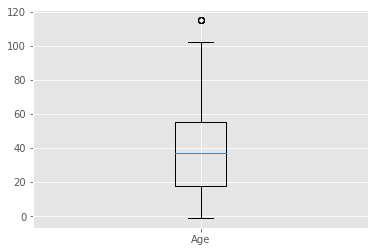

 115    5
 100    4
 102    2
 99     1
-1      1
Name: Age, dtype: int64

In [6]:
#This makes detecting the outliers visually easy (except for -1)
plt.boxplot(df['Age'], labels=['Age'])
plt.show()

#this helps to count the ages that need removed (-1 and 115)
df['Age'].value_counts().tail()

In [7]:
print('\n Handicap value counts:')
df['Handcap'].value_counts()


 Handicap value counts:


0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [8]:
#Making sure these are all zeros and ones 
df.SMS_received.unique(), df.Hipertension.unique(), df.Alcoholism.unique(), \
df.Diabetes.unique(), df.Scholarship.unique()

(array([0, 1]), array([1, 0]), array([0, 1]), array([0, 1]), array([0, 1]))

As we can see there are fortunately no null values, but this data still needs cleaned. The age value of-1 needs removed. The 5 people aged at 115 also needs removed (unlikely five people are living at that age). The 'Handcap' value range of 0-4 is not the same 0-1 range of the other features, so that will be preprocessed later. I will not remove the 3 people with 4 handicaps because I know much less about the max number of disbabilities a person can have than the max age people can live. 

In [9]:
# for the number of patients
df.PatientId.nunique()

62299

> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).

### Data Cleaning

In [10]:
#getting rid of the -1 in Age
df.drop(df[df.Age < 0].index, inplace=True)
#removes the supposed 115 year olds
df.drop(df[df.Age > 110].index, inplace=True)

In [11]:
#let's check to see if these rows are gone
print('New data shape:', df.shape)
print('New min age:', df.Age.min())
print('New max age:', df.Age.max())

New data shape: (110521, 14)
New min age: 0
New max age: 102


##### Let's add a column for the number of days between the scheduled day and appointment day. 

In [12]:
#difference between the these features after converting them to datetime using pd.to_datetime()
df['WaitDays'] = pd.to_datetime(df.AppointmentDay) - pd.to_datetime(df.ScheduledDay)

#Here we will find any recording errors where the scheduled date occurred after the appointment day)
df['WaitDays'] = df['WaitDays'].apply(lambda x: int(x.days))

In [13]:
#Checking to see how many of the appointment times are set after the time of scheduling. 
df.query('WaitDays < 0 ')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1
8,5.639473e+13,5638447,F,2016-04-29T08:02:16Z,2016-04-29T00:00:00Z,21,ANDORINHAS,0,0,0,0,0,0,No,-1
19,7.223289e+12,5640433,F,2016-04-29T10:43:14Z,2016-04-29T00:00:00Z,46,DA PENHA,0,0,0,0,0,0,No,-1
24,8.734858e+12,5641780,F,2016-04-29T14:19:19Z,2016-04-29T00:00:00Z,65,TABUAZEIRO,0,0,0,0,0,0,No,-1
26,2.578785e+10,5641781,F,2016-04-29T14:19:42Z,2016-04-29T00:00:00Z,45,BENTO FERREIRA,0,1,0,0,0,0,No,-1
28,5.926172e+12,5642400,M,2016-04-29T15:48:02Z,2016-04-29T00:00:00Z,51,SÃO PEDRO,0,0,0,0,0,0,No,-1


It shows that over 30,000 appointments are after the time of their scheduling, but that is not entirely true. It is actually the case that the appointments were done on the same day for most of these. It shows -1 for wait days because the exact time of day was not recorded for the atual appointment, and only for the scheduling time. So we can assume the scheduled day and appointment day are the same. However, are there any appointment times less than -1 (which would indicate error)?

In [14]:
df.query('WaitDays < -1')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays
27033,7.839273e+12,5679978,M,2016-05-10T10:51:53Z,2016-05-09T00:00:00Z,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,-2
55226,7.896294e+12,5715660,F,2016-05-18T14:50:41Z,2016-05-17T00:00:00Z,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,-2
64175,2.425226e+13,5664962,F,2016-05-05T13:43:58Z,2016-05-04T00:00:00Z,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,-2
71533,9.982316e+14,5686628,F,2016-05-11T13:49:20Z,2016-05-05T00:00:00Z,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,-7
72362,3.787482e+12,5655637,M,2016-05-04T06:50:57Z,2016-05-03T00:00:00Z,7,TABUAZEIRO,0,0,0,0,0,0,Yes,-2


Here we have only five. So I will just delete these, as these five entries distort the contribution of the WaitDays variable to the no-show outcome. 

In [15]:
df.drop(df.loc[df.WaitDays < -1].index, inplace = True)

#We will also convert the leftover -1 values to 0 because they scheduling day and appointment day were the same
df.WaitDays = df.WaitDays.apply(lambda x: 0 if x == -1 else x)
df.WaitDays.describe()

count    110516.000000
mean          9.533190
std          15.028018
min           0.000000
25%           0.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: WaitDays, dtype: float64

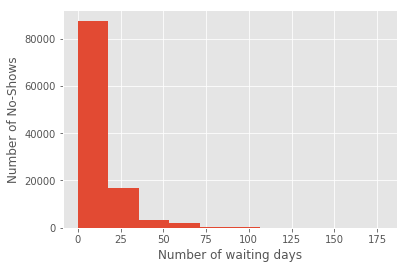

In [16]:
plt.hist(df.WaitDays)
plt.xlabel('Number of waiting days')
plt.ylabel('Number of No-Shows');

This has an expected strong positive-skew given hospital administrators and patients would generally want to minimize the time between scheduled and appointment dates. 

Now I'll drop the date columns and the id numbers. 

In [17]:
dates = df.loc[:, ['ScheduledDay', 'AppointmentDay']] #saves a copy of dates in variable
df.drop(['PatientId', 'AppointmentID', 'ScheduledDay', 'AppointmentDay'], axis=1, inplace=True)
 

In [18]:
df.head()

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0


In [19]:
#fixes the simple misspellings 
df = df.rename(columns={'No-show':'No_show', 'Handcap':'Handicap', 'Hipertension':'Hypertension', 'Neighbourhood': 'Neighborhood'})
df.head()

,Gender,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,WaitDays
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0


### Data Preprocessing

First, we will 1,0 encode these two columns: 'No-show' and 'Gender'. I used .apply() to ensure that every 'Yes' in the 'No-show' us a 1, and every 'No' is zero. So for every 1 there is a no-show, and for every 0 the patient showed up.

In [20]:
df2 = df.copy #this keeps the cleaned, though unprocessed original data in storage so we may access it for plotting

from sklearn import preprocessing
cat_features = ['color', 'director_name', 'actor_2_name']
enc = le()
enc.fit(cat_features)
new_cat_features = enc.transform(cat_features)
print new_cat_features # [1 2 0]
new_cat_features = new_cat_features.reshape(-1, 1) # Needs to be the correct shape
ohe = preprocessing.OneHotEncoder(sparse=False) #Easier to read
print ohe.fit_transform(new_cat_features)

In [21]:
#this creates 81 new columns with each column containing an 81 rows with one row as 1 and the rest 0s
df = pd.concat([df, pd.get_dummies(df.Neighborhood)], axis=1)
df.columns = df.columns.str.replace(' ', '_')
df.head()

,Gender,Age,Neighborhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMS_received,No_show,...,SANTOS_REIS,SEGURANÇA_DO_LAR,SOLON_BORGES,SÃO_BENEDITO,SÃO_CRISTÓVÃO,SÃO_JOSÉ,SÃO_PEDRO,TABUAZEIRO,UNIVERSITÁRIO,VILA_RUBIM
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,...,0,0,0,0,0,0,0,0,0,0
1,M,56,JARDIM DA PENHA,0,0,0,0,0,0,No,...,0,0,0,0,0,0,0,0,0,0
2,F,62,MATA DA PRAIA,0,0,0,0,0,0,No,...,0,0,0,0,0,0,0,0,0,0
3,F,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,...,0,0,0,0,0,0,0,0,0,0
4,F,56,JARDIM DA PENHA,0,1,1,0,0,0,No,...,0,0,0,0,0,0,0,0,0,0


Here I one-hot encode the No-show and Gender variable to 1s and 0s. 

In [22]:
df['Noshow_onehot'] = df['No_show'].apply(lambda x: 1 if x == 'Yes' else 0) #one-hot encodes 'Yes' to 1s and 'No' to 0s.
df['Gender_onehot'] = df['Gender'].apply(lambda x: 1 if x =='F' else 0) #encodes females to 1s and males to 0s 
print(df.Noshow_onehot.value_counts())

0    88205
1    22311
Name: Noshow_onehot, dtype: int64


In [23]:
df['Age_mmn'] = df.Age/df.Age.max()
df['WaitDays_mmn'] = df.WaitDays/df.WaitDays.max()

<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

The violin plot indicates that as the days between the scheduled date and the appointment date increases, the number of no-shows increases, but the effect of the wait time increase diminishes somewhere between 35 and 50 days, so the relationship appears to be nonlinear. The people who showed on the left reinforce this with most people showing up closest to zero days of waiting. 

The bar chart on the right makes it much more clear that around 16 days most people do not show up. 

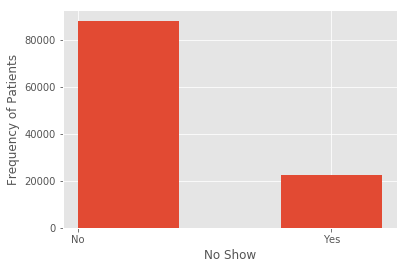

In [24]:
plt.hist(df['No_show'], bins=np.arange(0,1.4,.4))
plt.ylabel('Frequency of Patients')
plt.xlabel('No Show');

#Here we get a clear picture of how many no-shows at 1, and shows at 0.

## Research Question 1: What are the relative contributions of each feature to the no-show outcome? 

In [25]:
df.columns

Index(['Gender', 'Age', 'Neighborhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handicap', 'SMS_received', 'No_show',
       'WaitDays', 'AEROPORTO', 'ANDORINHAS', 'ANTÔNIO_HONÓRIO',
       'ARIOVALDO_FAVALESSA', 'BARRO_VERMELHO', 'BELA_VISTA', 'BENTO_FERREIRA',
       'BOA_VISTA', 'BONFIM', 'CARATOÍRA', 'CENTRO', 'COMDUSA', 'CONQUISTA',
       'CONSOLAÇÃO', 'CRUZAMENTO', 'DA_PENHA', 'DE_LOURDES', 'DO_CABRAL',
       'DO_MOSCOSO', 'DO_QUADRO', 'ENSEADA_DO_SUÁ', 'ESTRELINHA',
       'FONTE_GRANDE', 'FORTE_SÃO_JOÃO', 'FRADINHOS', 'GOIABEIRAS',
       'GRANDE_VITÓRIA', 'GURIGICA', 'HORTO', 'ILHA_DAS_CAIEIRAS',
       'ILHA_DE_SANTA_MARIA', 'ILHA_DO_BOI', 'ILHA_DO_FRADE',
       'ILHA_DO_PRÍNCIPE', 'ILHAS_OCEÂNICAS_DE_TRINDADE', 'INHANGUETÁ',
       'ITARARÉ', 'JABOUR', 'JARDIM_CAMBURI', 'JARDIM_DA_PENHA',
       'JESUS_DE_NAZARETH', 'JOANA_D´ARC', 'JUCUTUQUARA', 'MARIA_ORTIZ',
       'MARUÍPE', 'MATA_DA_PRAIA', 'MONTE_BELO', 'MORADA_DE_CAMBURI',
       'MÁRIO_CYPR

      Iter       Train Loss   Remaining Time 
         1           0.9888           41.40s
         2           0.9748           43.02s
         3           0.9633           42.93s
         4           0.9538           42.77s
         5           0.9459           42.21s
         6           0.9392           41.56s
         7           0.9336           40.95s
         8           0.9289           40.41s
         9           0.9249           39.80s
        10           0.9216           39.26s
        20           0.9062           34.61s
        30           0.9017           29.60s
        40           0.8996           24.43s
        50           0.8984           19.38s
        60           0.8972           15.01s
        70           0.8964           10.97s
        80           0.8956            7.11s
        90           0.8949            3.51s
       100           0.8944            0.00s

WaitDays_mmn       0.398493
Age_mmn            0.196305
SMS_received       0.034137
Alcoholism    

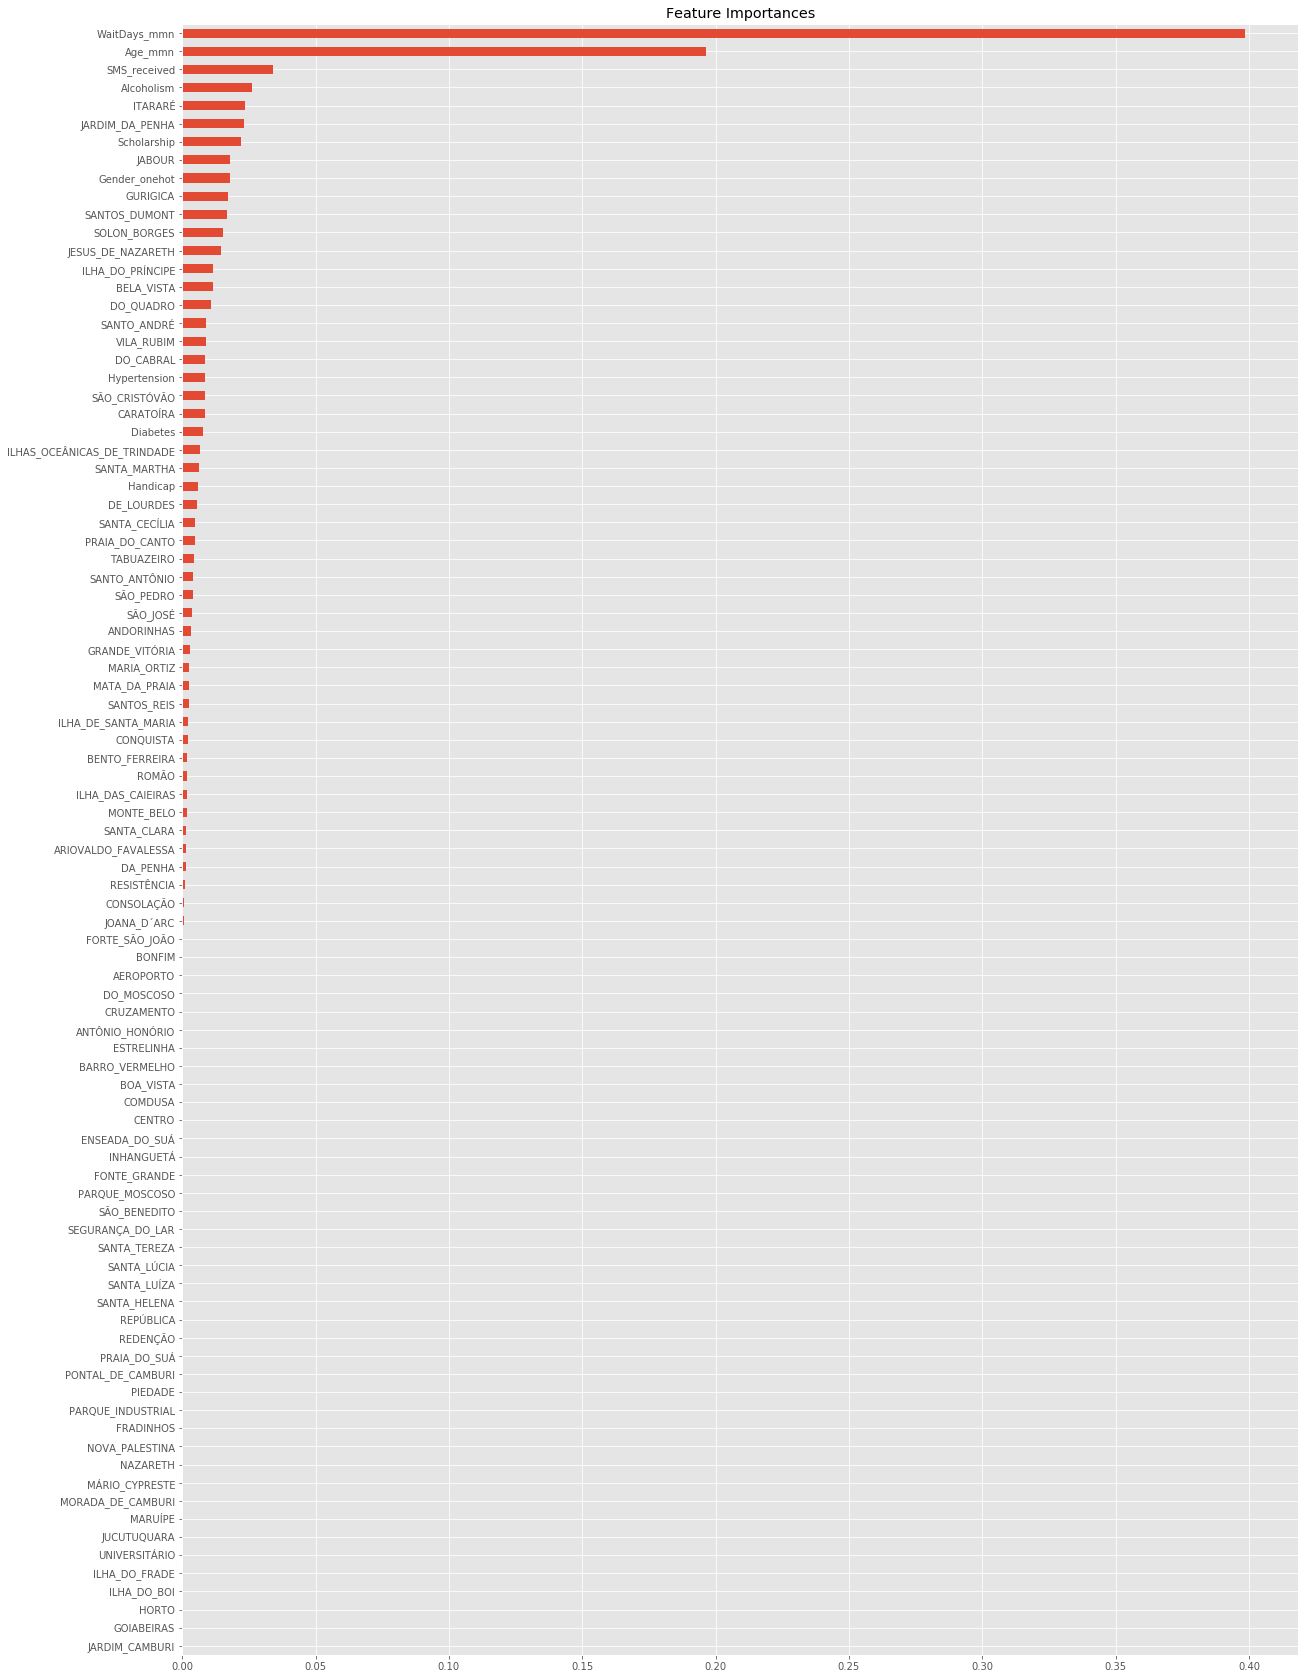

In [26]:
X = df.drop(['Gender', 'No_show', 'Noshow_onehot', 'Neighborhood', 'WaitDays', 'Age'], axis=1)
y = np.array(df.Noshow_onehot)
model = gbc(verbose=1)
model.fit(X,y)

plt.figure(figsize=(20,30))
feat_ranks = pd.Series(model.feature_importances_, X.columns).sort_values()
print()
print(feat_ranks.sort_values(ascending=False).head(6))
print()
feat_ranks.plot(kind='barh', title='Feature Importances');

So the top 5 variables, ranked from greatest relative importance to least importance are the following: 1. WaitDays 2. Age 3.SMS_received 4. Alcoholism 5. The Neighborhood: Itarare

## Research Question 2: Which explanatory variables have multicolinearity? That is, which variables highly correlate with each other, if any? 

In [27]:
df['intercept'] = 1
stats_model = sm.Logit(df.Noshow_onehot, df[['Alcoholism', 'Hypertension', 'Diabetes', 'Handicap', 'SMS_received', 'Scholarship', 'Gender_onehot', 'Age_mmn', 'WaitDays_mmn']])
results = stats_model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.519526
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:          Noshow_onehot   No. Observations:               110516
Model:                          Logit   Df Residuals:                   110507
Method:                           MLE   Df Model:                            8
Date:                Tue, 16 Oct 2018   Pseudo R-squ.:                -0.03286
Time:                        22:29:14   Log-Likelihood:                -57416.
converged:                       True   LL-Null:                       -55589.
                                        LLR p-value:                     1.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Alcoholism       -0.0495      0.045     -1.098      0.272      -0.138       0.039
Hypertension      0.

In [28]:
y, X = dmatrices("Noshow_onehot ~ Hypertension + Diabetes + Alcoholism + Handicap + SMS_received + Scholarship + Gender_onehot + Age_mmn + WaitDays_mmn + AEROPORTO + ANDORINHAS + ANTÔNIO_HONÓRIO + ARIOVALDO_FAVALESSA + BARRO_VERMELHO + BELA_VISTA + BENTO_FERREIRA + BOA_VISTA + BONFIM + CARATOÍRA + CENTRO + COMDUSA + CONQUISTA + CONSOLAÇÃO + CRUZAMENTO + DA_PENHA + DE_LOURDES + DO_CABRAL + DO_MOSCOSO + DO_QUADRO + ENSEADA_DO_SUÁ + ESTRELINHA + FONTE_GRANDE + FORTE_SÃO_JOÃO + FRADINHOS + GOIABEIRAS + GRANDE_VITÓRIA + GURIGICA + HORTO + ILHA_DAS_CAIEIRAS + ILHA_DE_SANTA_MARIA + ILHA_DO_BOI + ILHA_DO_FRADE + ILHA_DO_PRÍNCIPE + ILHAS_OCEÂNICAS_DE_TRINDADE + INHANGUETÁ + ITARARÉ + JABOUR + JARDIM_CAMBURI + JARDIM_DA_PENHA + JESUS_DE_NAZARETH + JUCUTUQUARA + MARIA_ORTIZ + MARUÍPE + MATA_DA_PRAIA + MONTE_BELO + MORADA_DE_CAMBURI + MÁRIO_CYPRESTE + NAZARETH + NOVA_PALESTINA + PARQUE_INDUSTRIAL + PARQUE_MOSCOSO + PIEDADE + PONTAL_DE_CAMBURI + PRAIA_DO_CANTO + PRAIA_DO_SUÁ + REDENÇÃO + REPÚBLICA + RESISTÊNCIA + ROMÃO + SANTA_CECÍLIA + SANTA_CLARA + SANTA_HELENA + SANTA_LUÍZA + SANTA_LÚCIA + SANTA_MARTHA + SANTA_TEREZA + SANTO_ANDRÉ + SANTO_ANTÔNIO + SANTOS_DUMONT + SANTOS_REIS + SEGURANÇA_DO_LAR + SOLON_BORGES + SÃO_BENEDITO + SÃO_CRISTÓVÃO + SÃO_JOSÉ + SÃO_PEDRO + TABUAZEIRO + UNIVERSITÁRIO + VILA_RUBIM", df, return_type = 'dataframe')
vif = pd.DataFrame()
vif['Variance_inflation_factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Features'] = X.columns

In [29]:
print(vif['Variance_inflation_factor'].values)

[ 82.50243845   1.62362692   1.25108579   1.05713199   1.01982288
   1.19510999   1.0763052    1.05003687   1.48970554   1.26115767
   1.005638     2.5330362    1.18833193   1.19525845   1.29498059
   2.3021853    1.59280923   1.21686354   2.87449919   2.73527653
   3.24450224   1.21499647   1.58490033   1.94141318   1.95670293
   2.51023322   1.21171178   1.38601229   1.28744685   1.58419688
   1.16365245   1.37476698   1.47025222   2.29012031   1.18028345
   1.48382341   1.73746148   2.37663081   1.12218317   1.73808735
   2.29206845   1.02465537   1.00723461   2.54449618   1.00148      1.72782763
   3.35550768   2.70418271   6.02131799   3.60495184   2.92573397
   1.48182411   4.83122602   2.29673361   1.4483016    1.57094415
   1.06701059   1.25734017   1.09426417   2.5419814    1.00071761
   1.5546018    1.31245207   1.04793695   1.71956356   1.88493094
   2.06363714   1.57784252   3.94322428   2.50575417   1.3113173
   1.34906533   1.12352045   1.29706538   1.30425795   3.1131319

The variation inflation factor test revealed that there is very weak correlation between the non-geographical and geographical predictors, with only one neighborhood above 5 (but since it's less than 10, we'll consider it an insignificant score), showing that multicolinearity did not affect the feature-importance ranking of the gradient boosting classifier with respect to these key variables. The rule of thumb regarding the value of a variance inflaction factor (VIF): if the VIF is above 10, it is problematic and necessitates omission or combination of one or more of the highly correlated variables. 

<a id='eda_waitdays'></a>
### Wait Days Exploration

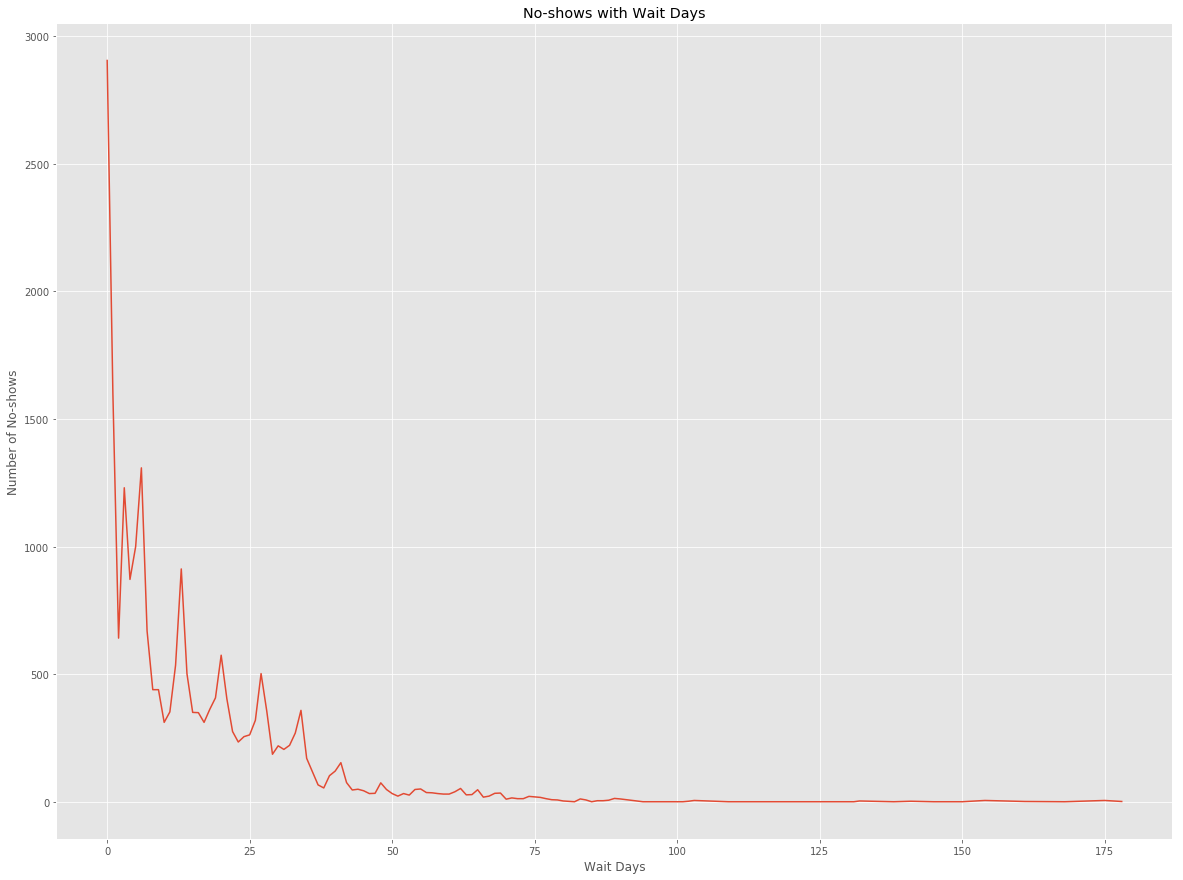

In [30]:
df['WaitDays_bins'] = pd.cut(df.WaitDays, 12)
df.query('No_show=="Yes"')['WaitDays_bins'].value_counts()

plt.figure(figsize=(20,15))
WD_series = pd.Series(df.query('No_show=="Yes"')['WaitDays'].value_counts().to_dict())
plt.plot(WD_series.index, WD_series.values)
plt.title('No-shows with Wait Days')
plt.xlabel('Wait Days')
plt.ylabel('Number of No-shows');

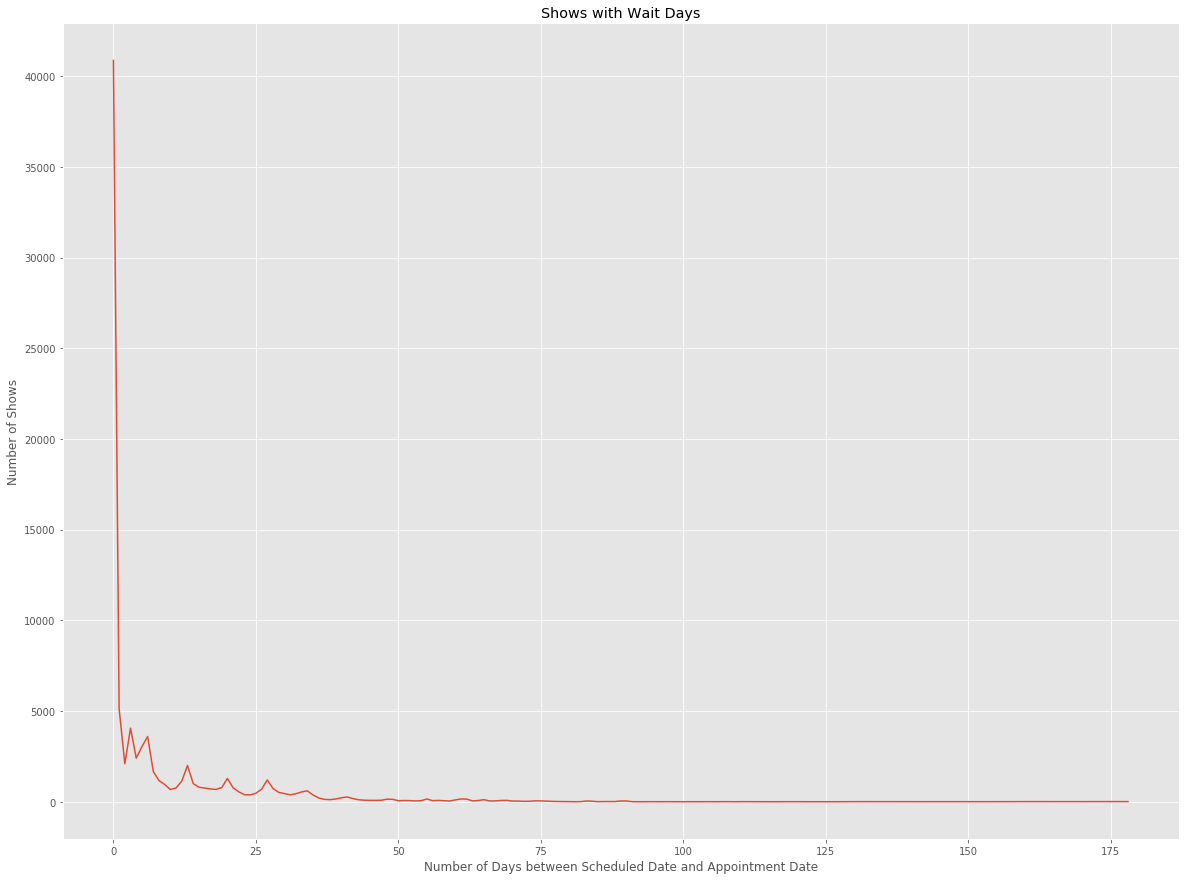

In [31]:
plt.figure(figsize=(20,15))
Wd_series_shows = pd.Series(df.query('No_show=="No"')['WaitDays'].value_counts().to_dict())
plt.plot(Wd_series_shows.index, Wd_series_shows.values)
plt.title('Shows with Wait Days')
plt.xlabel('Number of Days between Scheduled Date and Appointment Date')
plt.ylabel('Number of Shows');

Oddly, there is a counterintuitive negative correlation between the number of wait days and the number of no-show incidents. However, there is the intuitive negative correlation between the number of shows and the number of wait days: most of the people show up when the appointment is scheduled on the same day or closer to zero days between scheduled and appointment date.

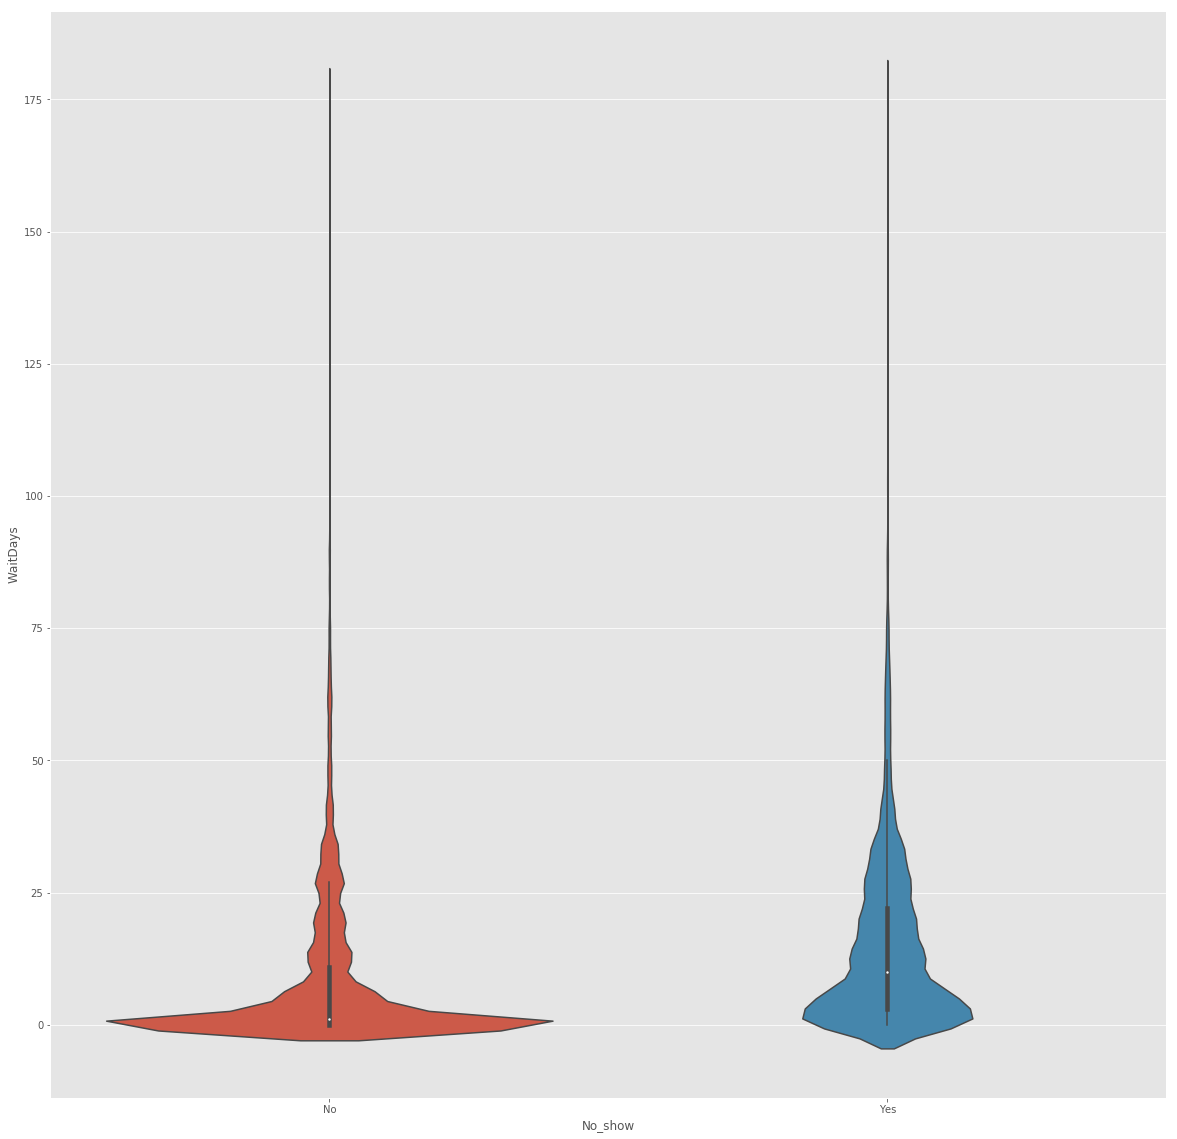

In [32]:
plt.figure(figsize=(20,20))
sb.violinplot(x = df['No_show'], y = df['WaitDays'], data=df);

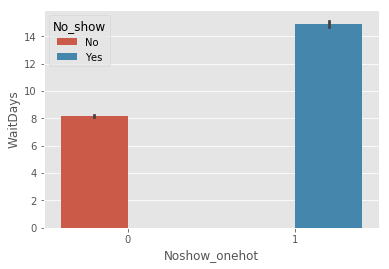

In [33]:
sb.barplot(x="Noshow_onehot", y="WaitDays", hue="No_show", data=df)

In [34]:
df.WaitDays.value_counts().to_dict()

{0: 43774,
 1: 6725,
 3: 5290,
 6: 4906,
 5: 4037,
 4: 3277,
 13: 2913,
 2: 2735,
 7: 2332,
 20: 1861,
 27: 1706,
 12: 1682,
 8: 1605,
 14: 1502,
 9: 1391,
 19: 1187,
 21: 1173,
 15: 1151,
 11: 1115,
 16: 1107,
 28: 1089,
 18: 1044,
 17: 1021,
 26: 1013,
 10: 987,
 34: 963,
 22: 822,
 33: 808,
 25: 731,
 29: 704,
 30: 672,
 32: 664,
 24: 637,
 23: 622,
 31: 586,
 35: 551,
 41: 417,
 40: 342,
 36: 331,
 42: 254,
 39: 254,
 48: 216,
 55: 203,
 62: 200,
 37: 198,
 61: 193,
 49: 182,
 38: 170,
 65: 162,
 43: 157,
 44: 137,
 60: 135,
 45: 121,
 47: 117,
 69: 112,
 57: 110,
 46: 109,
 54: 109,
 68: 105,
 56: 98,
 64: 97,
 52: 96,
 50: 91,
 51: 90,
 58: 90,
 63: 75,
 59: 73,
 53: 73,
 74: 72,
 67: 70,
 75: 65,
 66: 63,
 89: 58,
 90: 56,
 83: 54,
 71: 53,
 76: 53,
 70: 50,
 73: 39,
 84: 37,
 72: 37,
 77: 33,
 78: 23,
 79: 18,
 88: 17,
 87: 16,
 86: 16,
 175: 16,
 161: 11,
 132: 11,
 154: 10,
 178: 10,
 80: 10,
 82: 8,
 168: 8,
 103: 8,
 141: 8,
 85: 6,
 108: 5,
 107: 5,
 110: 5,
 94: 5,
 97: 5

The graphs suggest there is a significant correlation between the number of wait days and the number of people who will show up to their appointments, especially the bar graph that shows, on average, more wait days go with more people not showing. The violin plot demonstrates most people nearest zero wait days did show up to their appointment, however the largest proportion of people in the no-show group near or at zero wait days did not show up to their appointment. This violin plot also indicates that as the wait days increase the number of no-shows decreases, which is interesting given the 'common-sense' expectation of a stonger positive correlation between wait days and no-shows given people may tend to forget they had an appointment if they had to wait longer.

Given the feature of WaitDays only contributes to about 40% of the no-show outcome, a clear-cut linear relationship is not expected. 

<a id='eda_age'></a>
### Age

Text(0,0.5,'No-shows')

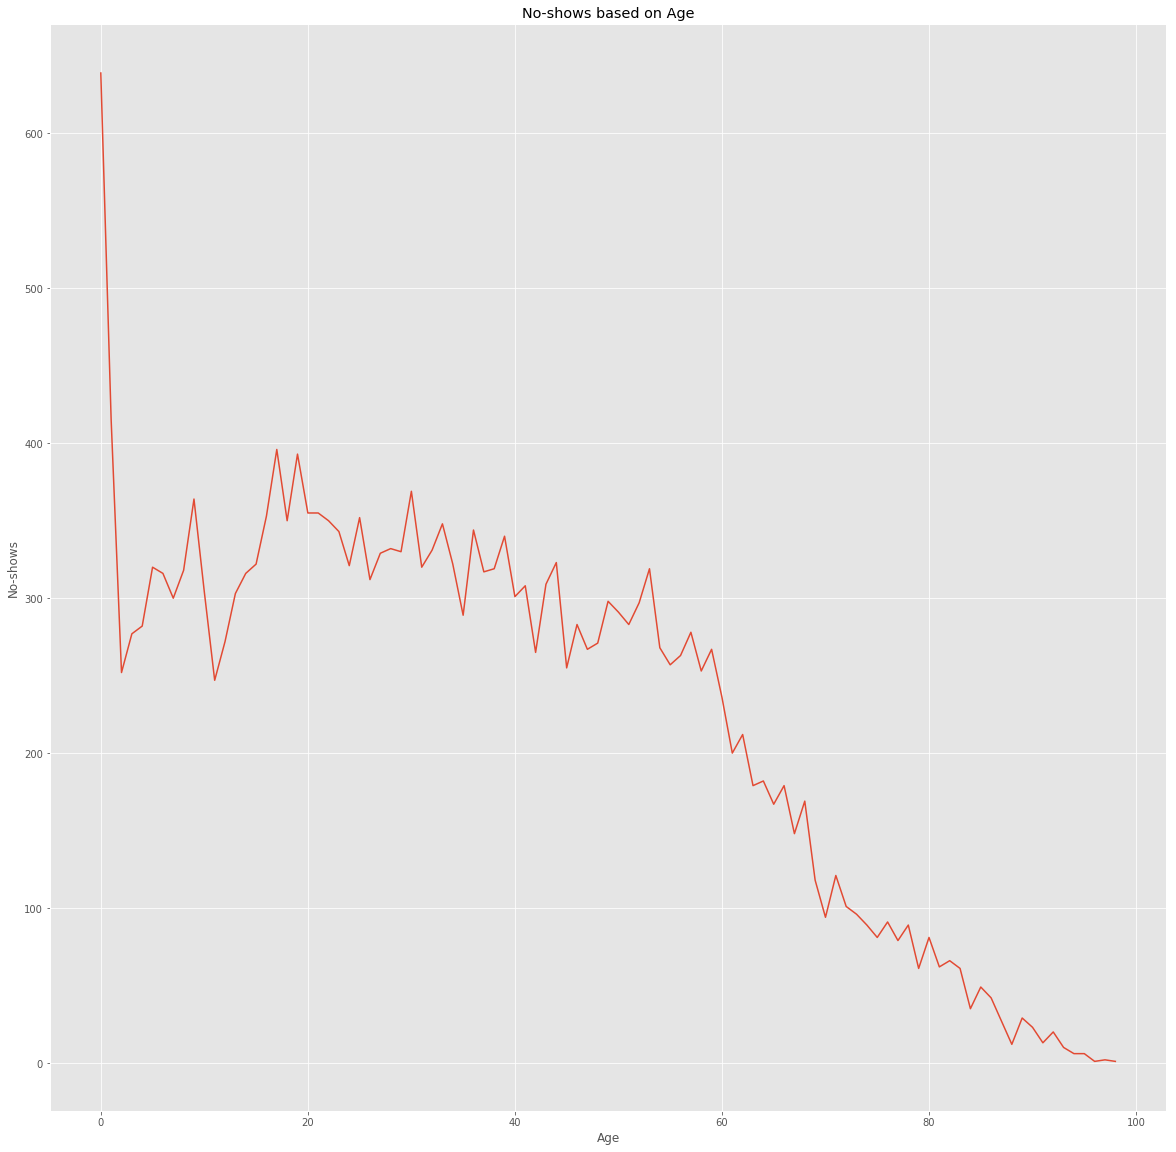

In [35]:
Age_series_noshow = pd.Series(df.query('No_show=="Yes"')['Age'].value_counts().to_dict())
plt.figure(figsize=(20,20))
plt.plot(Age_series_noshow.index, Age_series_noshow.values)
plt.title('No-shows based on Age')
plt.xlabel('Age')
plt.ylabel('No-shows')

Text(0,0.5,'Shows')

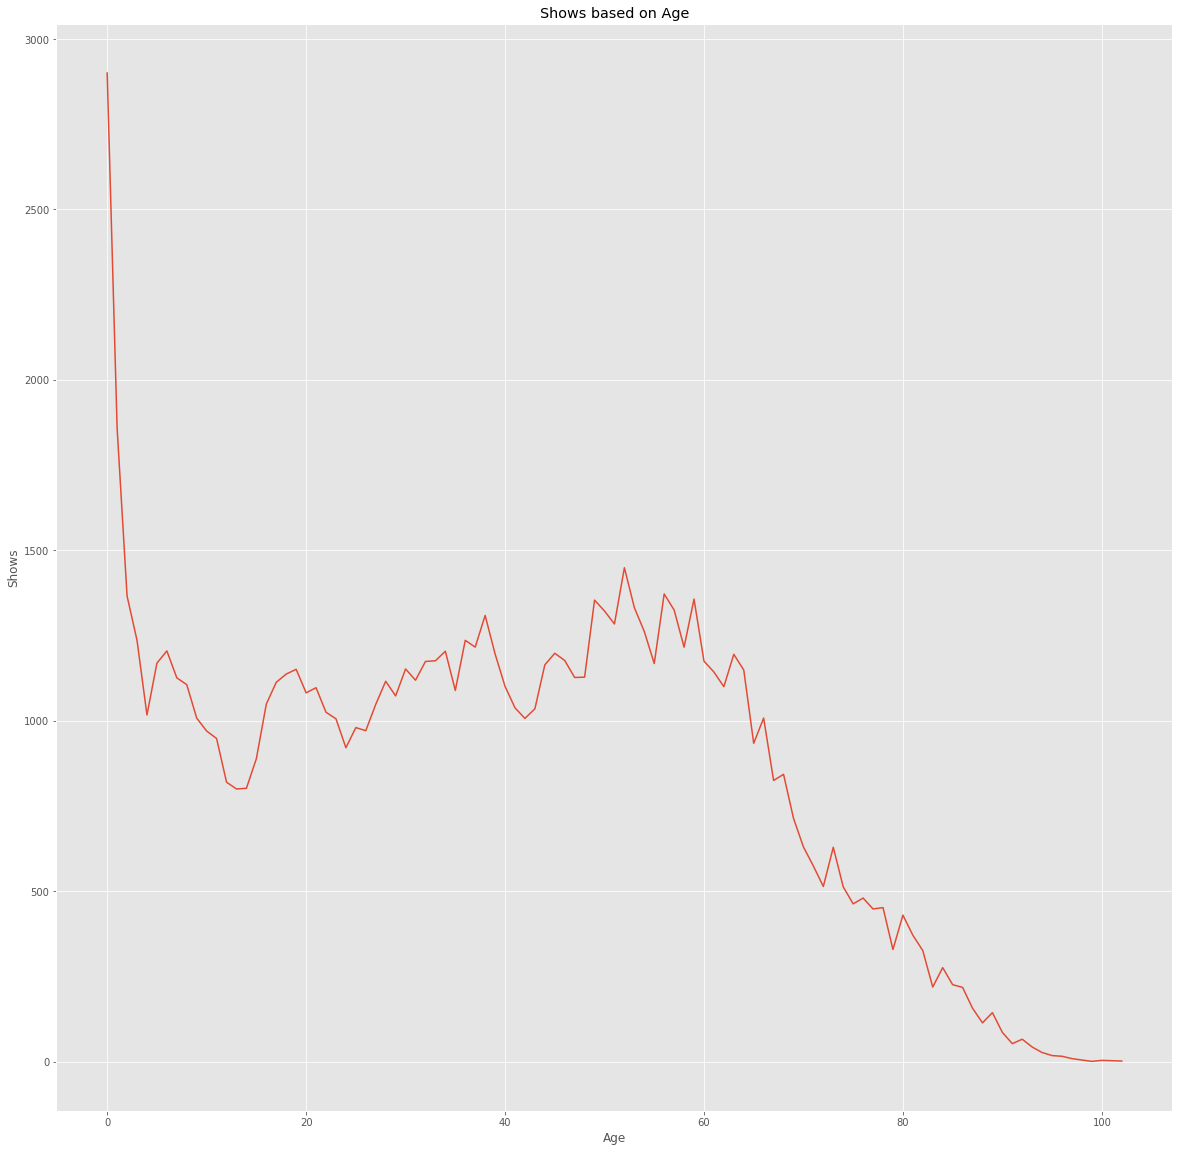

In [36]:
Age_series_noshow = pd.Series(df.query('No_show=="No"')['Age'].value_counts().to_dict())
plt.figure(figsize=(20,20))
plt.plot(Age_series_noshow.index, Age_series_noshow.values)
plt.title('Shows based on Age')
plt.xlabel('Age')
plt.ylabel('Shows')

In [37]:
df.Age.value_counts().sort_values(ascending=False)

0      3539
1      2273
52     1746
49     1652
53     1651
56     1635
38     1628
59     1624
2      1618
50     1613
57     1603
36     1580
51     1567
19     1544
39     1536
37     1533
54     1530
34     1526
33     1524
6      1521
30     1521
3      1513
17     1509
32     1505
5      1489
18     1487
44     1487
58     1469
46     1460
45     1453
       ... 
71      695
72      615
74      602
76      571
75      544
78      541
77      527
80      511
81      433
82      392
79      390
84      311
83      280
85      275
86      260
87      184
89      173
88      126
90      109
92       86
91       66
93       53
94       33
95       24
96       17
97       11
98        6
100       4
102       2
99        1
Name: Age, Length: 102, dtype: int64

The above graphs depict a noticeable negative correlation between the number of no-shows and age. Looking at the number of show-ups with age, there would should exist a decreasing number of shows with increasing age: there are fewer people in the population above 60 than people below 60 years. We can see a trend of increase between 20 and 60 in the number of shows, which fits the intuition that elderly people (>60 years) require more healthcare therefore accrure a greater cost from missing their hospital appointments. 

<a id='eda_text'></a>
### Text Messages

In [38]:
SMS_noshows = pd.Series(df.query('No_show == "Yes"')['SMS_received'].value_counts().to_dict())
SMS_shows = pd.Series(df.query('No_show == "No"')['SMS_received'].value_counts().to_dict())
print('No shows w.r.t Text Reminders: \n\n', SMS_noshows)
print()
print('Shows w.r.t Text Reminders: \n\n', SMS_shows)

No shows w.r.t Text Reminders: 

 0    12527
1     9784
dtype: int64

Shows w.r.t Text Reminders: 

 0    62508
1    25697
dtype: int64


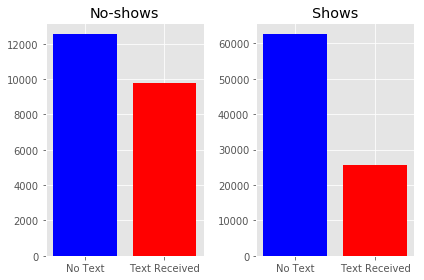

In [39]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.bar(x = SMS_noshows.index, height = SMS_noshows.values, tick_label=['No Text', 'Text Received'], color=['blue', 'red'])
ax1.set_title('No-shows')
ax2.bar(x = SMS_shows.index, height = SMS_shows.values, tick_label=['No Text', 'Text Received'], color=['blue', 'red'])
ax2.set_title('Shows')
fig.tight_layout();

The text message reminders only contributed about 3.4%. For all those who showed up to their appointment, more people in the no-text group showed up than people in the text-received group. Out of all the people who did not show to their appointments, there are more people who did not receive text reminders.

<a id='eda_alocholism'></a>
### Alcoholism

In [40]:
Alcohol_noshows = pd.Series(df.query('No_show == "Yes"')['Alcoholism'].value_counts().to_dict())
Alcohol_shows = pd.Series(df.query('No_show == "No"')['Alcoholism'].value_counts().to_dict())
print('No shows (w.r.t) Alcoholism: \n\n', Alcohol_noshows)
print()
print('Shows (w.r.t) Alcoholism: \n\n', Alcohol_shows)

No shows (w.r.t) Alcoholism: 

 0    21634
1      677
dtype: int64

Shows (w.r.t) Alcoholism: 

 0    85522
1     2683
dtype: int64


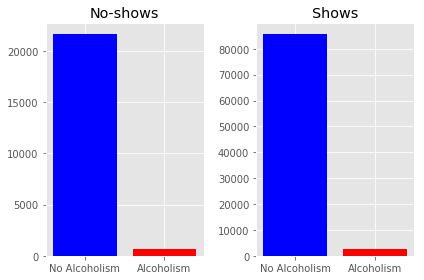

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.bar(x = Alcohol_noshows.index, height = Alcohol_noshows.values, tick_label=['No Alcoholism', 'Alcoholism'], color=['blue', 'red'])
ax1.set_title('No-shows')
ax2.bar(x = Alcohol_shows.index, height = Alcohol_shows.values, tick_label=['No Alcoholism', 'Alcoholism'], color=['blue', 'red'])
ax2.set_title('Shows')
fig.tight_layout();

For all people who showed up, about 79,000 more peopleare non-alcholics. However, for all people who did not show up, more people are non-alcholics, yet the difference is not as great as in the show-up group with only about a difference of 20,000. It is important to remember, according to the gradient boosting model for these Brazilian patients, alcoholism only contributes about 2.6% to predicting no-shows. 

<a id='eda_location'></a>
### Location

In [42]:
print((df.query('No_show == "Yes"')['Neighborhood'].value_counts()/df.Neighborhood.value_counts()).sort_values(ascending=False))

ILHAS OCEÂNICAS DE TRINDADE    1.000000
SANTOS DUMONT                  0.289185
SANTA CECÍLIA                  0.274554
SANTA CLARA                    0.264822
ITARARÉ                        0.262664
JESUS DE NAZARETH              0.243954
HORTO                          0.240000
ILHA DO PRÍNCIPE               0.234775
CARATOÍRA                      0.230409
ANDORINHAS                     0.229407
PRAIA DO SUÁ                   0.228261
GURIGICA                       0.225966
BENTO FERREIRA                 0.224942
PARQUE MOSCOSO                 0.223192
MARUÍPE                        0.222923
DO MOSCOSO                     0.222760
ENSEADA DO SUÁ                 0.221277
ARIOVALDO FAVALESSA            0.219858
ILHA DAS CAIEIRAS              0.219421
FONTE GRANDE                   0.218475
CRUZAMENTO                     0.217454
SÃO JOSÉ                       0.216599
BARRO VERMELHO                 0.215130
NAZARETH                       0.214815
ROMÃO                          0.214092


In [43]:
df.Neighborhood.value_counts()

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4430
JARDIM DA PENHA                3877
ITARARÉ                        3514
CENTRO                         3334
SANTA MARTHA                   3131
TABUAZEIRO                     3131
JESUS DE NAZARETH              2853
BONFIM                         2773
SANTO ANTÔNIO                  2744
SANTO ANDRÉ                    2571
CARATOÍRA                      2565
JABOUR                         2509
SÃO PEDRO                      2448
ILHA DO PRÍNCIPE               2266
NOVA PALESTINA                 2264
ANDORINHAS                     2258
DA PENHA                       2217
ROMÃO                          2214
GURIGICA                       2018
SÃO JOSÉ                       1976
BELA VISTA                     1907
MARUÍPE                        1902
FORTE SÃO JOÃO                 1889
ILHA DE SANTA MARIA            1885
SÃO CRISTÓVÃO                  1836
REDENÇÃO                    

The neighborhood 'ILHAS OCEÂNICAS DE TRINDADE' only has 2 appointments, so it's proportion of no-shows for total appointments is not valid. Yet, the other three above Itarare have over 100 appsointments each(Santos Dumont: 1,276, Santa Cecilia: 448, Santa Clara: 506), yet Itarare has 3,514 total appointments, almost triple Santos Dumont, so that explains why it has highest proportion of predictive contribution than the three above. Jardim da Penha, ranked 6, has more appointments than Itarare at 3,877, but the proportion of no-shows to total appointments is only 0.16, so this fits the intuition of it having a lower rank if relative importance (

<a id='conclusions'></a>
## Conclusions

The above gradient boosting machine model and the variance-inflation-factor test suggest that the most important variables to predict no-shows, with statistically insignificant correlations among the explanatory variables, are the following: (1) Time between Scheduled and Appointment date, or 'WaitDays' (2) Age of patient (3) Text Message reminder sent to Patient (4) Patient Alcoholism, and (5) the neighborhood of Itarare. This implies that personal features of the patient are more predictive than the location, the hopsital features. 

The findings are tentative mainly due to the lack of data: only 62,299 patients and less than 120,000 data entries. One very important condition for effective prediction using supervised machine learning models is to have hundreds of thousands, if not millions, of data points. In addition, the top five features only sum up to 67.8% of predictive contribution to the no-show outcome. 

Some features are missing that could make a machine learning model more predictive. One, a feature that would likely be within the top 10 relatively most important features is the hospital ranking, but this not immediately or easily attainable given only the neighborhood names were given, not the institution names. Two, the deductive feature of a running tally of prior missed appointments. Though this would not be helpful for the first appointment, it could be very predictive, but I did not calculate a running no-show tally as it is not an insight into the deeper cause or mechanism driving such behavior. Three, time was not broken down into the day of the week and hour, which may affect the no-show outcome. For example, maybe more people would show up on the weekend since they do not have to work (or whatever time most Brazilians do not work).  



## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

## References 


I learned Variance Inflation Factor from these two sources: 
(a) website: https://etav.github.io/python/vif_factor_python.html
(b) Udacity Screencast: https://classroom.udacity.com/nanodegrees/nd002/parts/682048c9-4e1a-4020-8a47-7eaf3e34f0fe/modules/e4508dac-d083-427b-be3d-63663aeada68/lessons/49462f74-b030-4bb6-bf67-8281c9181404/concepts/11f71035-3e54-43b2-a276-c2c65ebb82c2

For plotting distributions side by side for comparisons: http://benalexkeen.com/feature-scaling-with-scikit-learn/

Helped my find feature importances: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

Alfred Wong's completed project from Kaggle: https://www.kaggle.com/alfrednfwong/eda-no-shows-at-brazil-medical-appointments

Filtering outliers:
https://stackoverflow.com/questions/34782063/how-to-use-pandas-filter-with-iqr

Removing rows:
https://stackoverflow.com/questions/26921651/how-to-delete-the-last-row-of-data-of-a-pandas-dataframe